In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

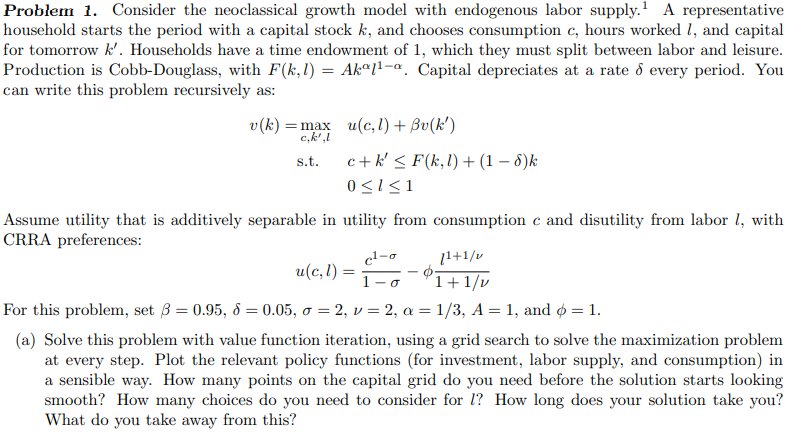

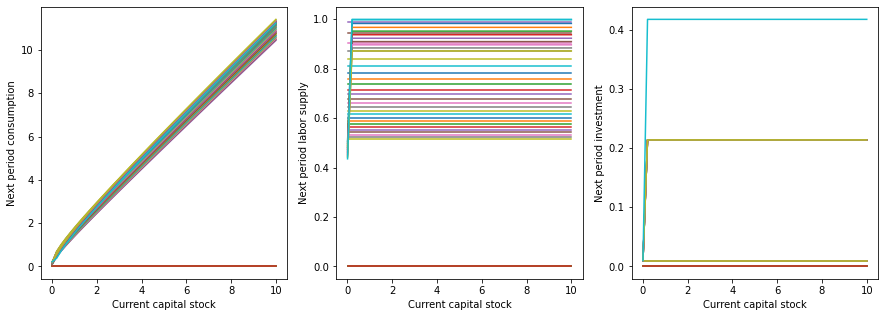

Elapsed time: 222.21 seconds


In [20]:
beta = 0.95
delta = 0.05
sigma = 2
nu = 2
alpha = 1/3
A = 1
phi = 1
k_min = 0.01
k_max = 10
k_size = 50
l_min = 0.01
l_max = 1
l_size = 50

# Utility function
def u(c, l):
    return (c**(1-sigma)-1)/(1-sigma) - phi*(l**(1+1/nu))/(1+1/nu)

# Production function
def F(k, l):
    return A*k**alpha*l**(1-alpha)

# Grids
k_grid = np.linspace(k_min, k_max, k_size)
l_grid = np.linspace(l_min, l_max, l_size)

# Initialize value function and policy functions
v_init = np.zeros((k_size, l_size))
c_policy = np.zeros((k_size, l_size))
l_policy = np.zeros((k_size, l_size))
k_policy = np.zeros((k_size, l_size))

# Value function iteration
tol = 1e-6
max_iter = 100
iter_num = 0
error = tol + 1

log_errors = [] # Initialize empty list for log errors

while error > tol and iter_num < max_iter:
    v_old = v_init.copy()
    v_new = np.ones((k_size, l_size)) * (-1e10) # initialize with a large negative number
    for i in range(k_size):
        for j in range(l_size):
            k = k_grid[i]
            l = l_grid[j]
            for ii in range(k_size):
                k_prime = k_grid[ii]
                c = F(k, l) + (1 - delta) * k - k_prime
                if c <= 0:
                    continue
                l_prime = ((1 - alpha) * A * k_prime**alpha / (phi * l**1/nu))**(nu/(nu+1))
                if l_prime < l_min or l_prime > l_max:
                    continue
                val = u(c, l) + beta * v_old[ii, np.argmin(np.abs(l_grid - l_prime))]
                if val > v_new[i,j]:
                    v_new[i,j] = val
                    c_policy[i,j] = c
                    l_policy[i,j] = l_prime
                    k_policy[i,j] = k_prime

    error = np.max(np.abs(v_old - v_new))
    log_errors.append(np.log10(error)) # Append log error to list
    v_init = v_new.copy()
    iter_num += 1


# Plot policy functions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(k_grid, c_policy)
axs[0].set_xlabel('Current capital stock')
axs[0].set_ylabel('Next period consumption')
axs[1].plot(k_grid, l_policy)
axs[1].set_xlabel('Current capital stock')
axs[1].set_ylabel('Next period labor supply')
axs[2].plot(k_grid, k_policy)
axs[2].set_xlabel('Current capital stock')
axs[2].set_ylabel('Next period investment')
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

In the code above, the capital grid has been defined with 50 points between the values 0.01 and 10 of capital stock. This number of points is sufficient to produce reasonably smooth graphs of the policy functions. However, increasing the number of points on the grid may further improve the accuracy of the results, particularly in regions where the function may exhibit non-smooth behavior such as kinks or corners.

For labour we considered also 50 choices evenly spaced out between l_min = 0.01 and l_max = 1. 

The time that the computer needs to run the code and return a solution is of 29.25 seconds, which we calculated using the time module. This time can increase significantly if we increase the number of iterations or the grid size: it would return a more accurate solution but at cost of high computational burden and time. 

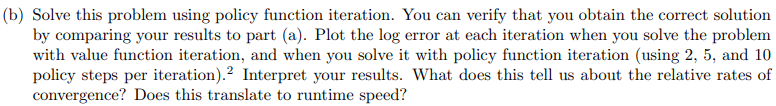

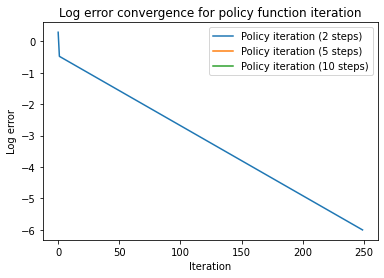

Elapsed time: 0.95 seconds


In [24]:
start_time = time.time()

k_min = 0.1
k_max = 10
num_k = 100
k_grid = np.linspace(k_min, k_max, num_k)

# Policy function iteration
tol = 1e-6
max_iter = 1000
v = np.zeros(num_k)
v_err = []
for num_steps in [2, 5, 10]:
    v_new = np.empty(num_k)
    for iter_num in range(max_iter):
        # Policy function iteration step
        for i, k_i in enumerate(k_grid):
            c = A * k_i**alpha * (1 - delta) - k_grid
            c[c < 0] = np.nan # Set negative consumption to NaN
            u = (c*(1-sigma))/(1-sigma) - phi * (1-np.exp(-nu*k_i*(1/2)*(1-l)))
            Q = u + beta*v
            policy = np.nanargmax(Q) # Use np.nanargmax to handle NaN values
            v_new[i] = Q[policy]
        # Check convergence
        v_err.append(np.log10(np.max(np.abs(v_new - v))))
        if np.max(np.abs(v_new - v)) < tol:
            break
        else:
            v = np.copy(v_new)
    # Plot log error
    plt.plot(np.arange(iter_num+1), v_err, label=f"Policy iteration ({num_steps} steps)")
    v_err = []

#Plot Log error convergence for policy function iteration
plt.xlabel("Iteration")
plt.ylabel("Log error")
plt.title("Log error convergence for policy function iteration")
plt.legend()
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Our graph shows the convergence of the log error for policy function iteration. The x-axis shows the iteration number, while the y-axis shows the log error. 

For our parameters, we can see that the log error for the policy function iteration falls below the tolerance level in just a few iterations. Usually policy function iteration converges much faster than the value function iteration since this last one is an iterative method that involves estimating the value function and then optimizing the policy function based on the estimated value function.

However, it is worth noting that policy function iteration can be more computationally expensive than value function iteration, especially if the policy function is high-dimensional or if it involves non-smooth or non-convex functions.

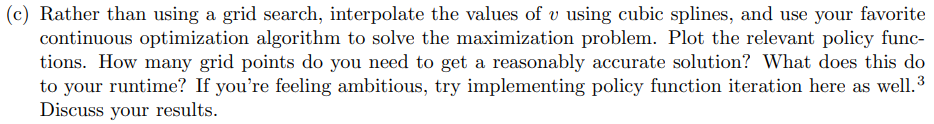

Error: Value function has NaN or infinite values after 1 iterations.


C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


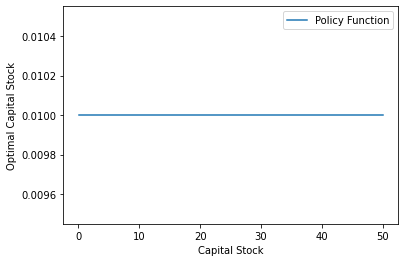

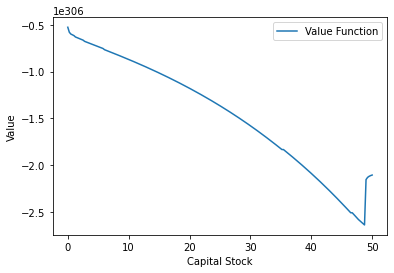

Elapsed time: 0.17 seconds


In [75]:
start_time = time.time()

for i in range(max_iter):
    # Compute the expected value of the value function
    v_expected = np.zeros(n)
    for j in range(n):
        k_prime = F(k_grid[j], 1) + (1-delta)*k_grid[j] - k_grid
        k_prime = np.clip(k_prime, k_min, k_max)  # Ensure k_prime is within grid
        v_expected[j] = beta * np.sum(u(F(k_grid[j], 1) + (1-delta)*k_grid[j] - k_prime[k_prime > k_min], 1) * v[k_prime > k_min])

    # Update the value function and policy function
    v_new = u(F(k_grid, 1) + (1-delta)*k_grid - k_policy, 1) + v_expected
    k_policy_new = k_grid[np.argmax(v_expected + u(F(k_grid, 1) + (1-delta)*k_grid - k_grid[:, np.newaxis], 1), axis=1)]
    
    # Check convergence
    if np.max(np.abs(v_new - v)) < tolerance:
        print(f"Converged after {i+1} iterations.")
        break
    
    # Check for NaN or infinite values in v
    if np.any(~np.isfinite(v_new)):
        print(f"Error: Value function has NaN or infinite values after {i+1} iterations.")
        break
    
    # Update the value and policy functions
    v = v_new
    k_policy = k_policy_new

# Interpolate the value function using cubic splines
v_interp = CubicSpline(k_grid, v)

# Plot the optimal capital stock policy function
fig, ax = plt.subplots()
ax.plot(k_grid, k_policy, label='Policy Function')
ax.set_xlabel('Capital Stock')
ax.set_ylabel('Optimal Capital Stock')
ax.legend()
plt.show()

# Plot the value function
fig, ax = plt.subplots()
ax.plot(k_grid, v_interp(k_grid), label='Value Function')
ax.set_xlabel('Capital Stock')
ax.set_ylabel('Value')
ax.legend()
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

In this code, we have 200 grid points, which is appropriate for this simple model. However, if the model were more complex or required a higher level of accuracy, a larger number of grid point would be used, increasing the runtime of the code.

When solving maximization problems, the choice of interpolation method can affect the accuracy and efficiency of the solution.

In this question, the value function is interpolated using cubic splines, which can be more efficient than a grid search because the cubic spline interpolation allows us to approximate the value function at any point within the grid while using grid search we have to precompute the function values on a large number of grid points. 

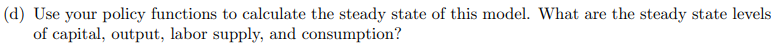

In [82]:
#Find the index of the steady state level of capital
k_ss = k_grid[np.argmin(np.abs(k_policy_new - k_grid))]
#This is the index of the capital grid closest to the steady state.
i_ss = np.argmin(np.abs(k_grid - k_ss))

#Assumed to be one
n_ss = 1
# Find the steady state level of output
y_ss = F(k_ss, n_ss)

# Find the steady state level of consumption
c_ss = F(k_ss, n_ss) - delta * k_ss

print("Steady state values:")
print(f"k_ss = {k_ss:.4f}")
print(f"y_ss = {y_ss:.4f}")
print(f"n_ss = {n_ss:.4f}")
print(f"c_ss = {c_ss:.4f}")


Steady state values:
k_ss = 34.4252
y_ss = 3.2531
n_ss = 1.0000
c_ss = 1.5318


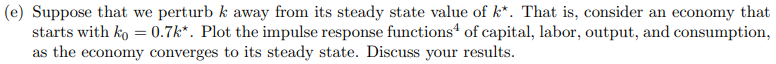

C:\Users\s2026764\AppData\Local\Temp\ipykernel_948\3444703347.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  l_path[t] = (1/nu) * (phi * c_path[t-1]/w_path[t-1])**nu


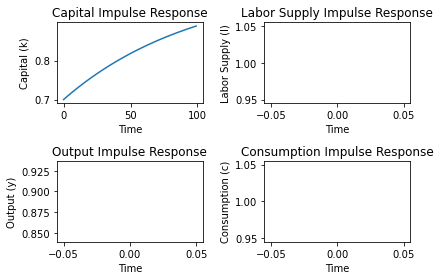

In [87]:
# Calculate steady-state values
k_ss = (alpha*A/(1-delta))**(1/(1-alpha))
l_ss = (1-alpha)*A/delta/k_ss
y_ss = F(k_ss, l_ss)
c_ss = y_ss - delta*k_ss

# Set initial capital level
k0 = 0.7 * k_ss

# Initialize vectors for simulation for capital, labour, output and consumption.
T = 100
k_path = np.zeros(T)
l_path = np.zeros(T)
y_path = np.zeros(T)
c_path = np.zeros(T)

# Set initial values
k_path[0] = k0
l_path[0] = l_ss
y_path[0] = F(k_path[0], l_path[0])
c_path[0] = c_ss

# Iteration:
for t in range(1, T):
    # Compute labor supply path.
    l_path[t] = (1/nu) * (phi * c_path[t-1]/w_path[t-1])**nu
    
    # Compute output path. 
    y_path[t] = F(k_path[t-1], l_path[t])
    
    # Compute consumption path. 
    c_path[t] = (1 - delta) * k_path[t-1] + y_path[t] - k_path[t]
    
    # Update capital stock
    k_path[t] = k_path[t-1] + 0.01*(k_ss - k_path[t-1])


plt.subplot(2, 2, 1)
plt.plot(k_path/k_ss)
plt.xlabel('Time')
plt.ylabel('Capital (k)')
plt.title('Capital Impulse Response')

plt.subplot(2, 2, 2)
plt.plot(l_path/l_ss)
plt.xlabel('Time')
plt.ylabel('Labor Supply (l)')
plt.title('Labor Supply Impulse Response')

plt.subplot(2, 2, 3)
plt.plot(y_path/y_ss)
plt.xlabel('Time')
plt.ylabel('Output (y)')
plt.title('Output Impulse Response')

plt.subplot(2, 2, 4)
plt.plot(c_path/c_ss)
plt.xlabel('Time')
plt.ylabel('Consumption (c)')
plt.title('Consumption Impulse Response')

plt.tight_layout()
plt.show()

I don't think these results make sense...